# Understanding Etsy Reorders

Authors: Carlo Colizzi, Andrew Kurtz

## Intro

Andrew has been running a stationery and greeting card business on Etsy for the past 4 years.
During this time, he was able to fulfill thousands of orders, and now would like to understand
what pushes customers to order again, in an attempt to increase customer retention.

We will try to do this by analyzing the order data obtained through the Etsy API, looking specifically
at how often and when customers reorder, as well as the general characteristics of those orders (order size, etc...).

Acquiring new customers is time-consuming and expensive. Therefore, figuring out how to what drives
customer loyalty and improving that would be an easy path for growth. For example, if many customers
reorder for specific occasions as gifts (graduation, Christmas, etc), then sending out targeted
marketing to past customers around those events would be an efficient way to retain customers.

To make sure the code runs correctly, run the cell below:

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from api_lib import get_all_orders, get_all_reviews, read_json, extract_data
import matplotlib.pyplot as plt
from collections import Counter
import plotly.express as px
import pandas as pd
import statistics
from datetime import datetime

## Obtaining the Data

To access the data we requested access to the Etsy API to get an initial access key and credentials from Etsy, then went through the authentication steps to connect it to Andrew's Etsy shop to get updated keys that enable access the private order and review data from the shop.

Using those keys we wrote a python library in the file `api_lib.py` to pull all of the orders and reviews and save them as JSONs. For each order, the API gives us all relavant details including user ID information, shipping detials, all the items in order, total value, and date/time placed. In our analysis only need a fraction of the data. These are the key data points we use from orders:

- `buyer_user_id`: Integer thats a unique identifying id used to keep track of buyers to determine repeat customers
- `create_timestamp`: Unix timestamp for when order was created
- `state`: String with state name abbreviation from shipping address
- `subtotal`: Dictionery with keys:
    - `amount`: Order subtotal amount as int
    - `divisor`: Int representing what value to divide `amount` by to get dollar amount

From the reviews dataset, we only accessed the `buyer_user_id` value which represents the same thing as `buyer_user_id` in the order dataset.

To pull the data and save it locally, we ran the cell below with two functions from our api_lib.py library. We only needed to run this at the beginning and after a few days has passed to update the data with the latest orders. By saving it locally, we can mitigate calls to the API.

In [2]:
KEY_PATH = "keys.json"
ORDERS_PATH = "orders.json"
REVIEWS_PATH = "reviews.json"
SHOP_ID = 23574688

get_all_orders(KEY_PATH, ORDERS_PATH, SHOP_ID)
get_all_reviews(KEY_PATH, REVIEWS_PATH, SHOP_ID)

This cell is used to read the locally stored order and review data, storing them in their respective variables as lists of dictionaries.

In [3]:
orders = read_json('orders.json')
reviews = read_json('reviews.json')

To pull the specific data points mentioned above, we wrote a function called 'extract_data' which extracts the data from all orders stored in parameter_1 and optionally parameter_2 and returns a list. This function will be used throughout the essay.

## Analyzing the Data

### Understanding the number of customers that reorder

In the first step of our analysis, we decided to understand the split between one-off customers and returning customers. We did this by taking all customer ids from all orders, stored in `buyer_user_id`, and using a `Counter()` function to check which ones appear multiple times. You can notice one customer id has been removed. This is because that account in particular was an account used to place test orders, and therefore would skew the data. Once we knew how many orders were repeat orders, and how many were one-off, we were able to represent this on a pie chart.

Counter({1: 1811, 2: 182, 3: 43, 4: 12, 5: 9, 6: 2, 8: 1})
dict_keys([1, 2, 3, 4, 6, 5, 8])
dict_values([1811, 182, 43, 12, 2, 9, 1])


Text(0.5, 1.0, 'How many orders a customer places')

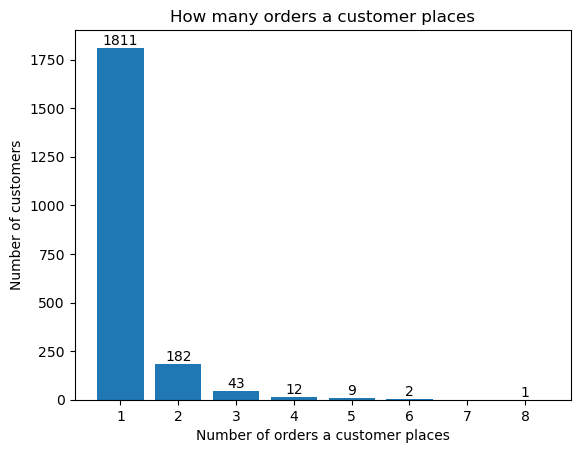

In [10]:
buyer_user_id = extract_data(orders, "buyer_user_id")

num_orders_by_customers = list(Counter(buyer_user_id).values())

num_orders_by_customers.remove(37)

orders_per_customer = Counter(num_orders_by_customers)

num_reorders = orders_per_customer.keys()
num_customers = orders_per_customer.values()

print(orders_per_customer)

labels = [str(item) for item in list(num_customers)]

print(num_reorders)
print(num_customers)

fig, ax = plt.subplots()
bars = ax.bar(num_reorders, num_customers, label=labels)

# Adding labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, yval, ha='center', va='bottom')

plt.xlabel("Number of orders a customer places")
plt.ylabel("Number of customers")
plt.title("How many orders a customer places")

### Understanding the time between re-orders

Once we were able to isolate the repeat customers, we became curious to understand whether there was any pattern in when the orders occurred. We created a dictionary mapping the order date(s) to the customer id. This allowed us to calculate the time differences between orders made by the same customers, which we then plotted on a violin plot.

{833549482: [datetime.datetime(2024, 3, 26, 16, 37, 16)], 117847284: [datetime.datetime(2024, 3, 26, 13, 7, 26)], 913694390: [datetime.datetime(2024, 3, 25, 20, 38, 28)], 913700507: [datetime.datetime(2024, 3, 25, 17, 46, 38)], 35583833: [datetime.datetime(2024, 3, 25, 17, 2, 54)], 99507184: [datetime.datetime(2021, 6, 3, 10, 4, 59), datetime.datetime(2024, 3, 25, 16, 10, 3)], 22465837: [datetime.datetime(2024, 3, 25, 8, 46, 54)], 913205500: [datetime.datetime(2024, 3, 24, 12, 50, 41)], 912984215: [datetime.datetime(2024, 3, 23, 15, 47, 4)], 311148178: [datetime.datetime(2024, 3, 22, 18, 13, 3)], 717790107: [datetime.datetime(2024, 3, 22, 15, 47, 13)], 912650087: [datetime.datetime(2024, 3, 22, 14, 24, 10)], 283822452: [datetime.datetime(2024, 3, 22, 9, 38, 40)], 8099127: [datetime.datetime(2024, 3, 20, 10, 52, 14)], 324120147: [datetime.datetime(2020, 6, 15, 14, 52, 54), datetime.datetime(2020, 6, 24, 18, 56, 37), datetime.datetime(2020, 6, 24, 19, 10, 8), datetime.datetime(2020, 6, 2

([], [])

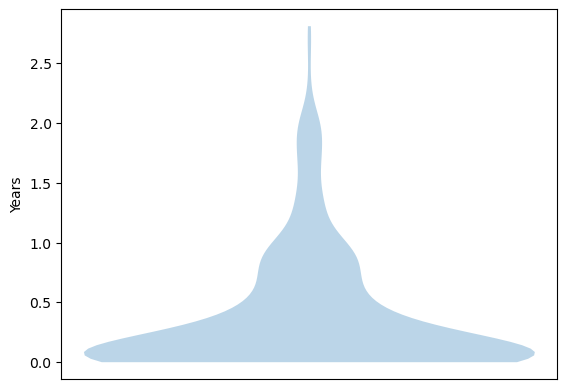

In [5]:
order_time = extract_data(orders, 'create_timestamp')

for i in range(len(order_time)):
    order_time[i] = datetime.fromtimestamp(order_time[i])

orders_by_customer = {}

for customer_id, order_time in zip(buyer_user_id, order_time):
    if customer_id not in orders_by_customer:
        orders_by_customer[customer_id] = []
    orders_by_customer[customer_id].append(order_time)

# Initialize a list to hold all time differences
all_time_diffs = []

# Calculate time differences for all customers
for times in orders_by_customer.values():
    times.sort()  # Ensure times are in chronological order
    if len(times) > 1:
        # Calculate the deltas and extend the all_time_diffs list
        all_time_diffs.extend([times[i] - times[i-1] for i in range(1, len(times))])
print(orders_by_customer)
years = [t.days / 365.25 for t in all_time_diffs]
plt.violinplot(years, showmeans=False, showmedians=False,showextrema=False)
plt.ylabel('Years')
plt.xticks([])

### Understanding the dates of reorders

We noticed most of the repeat orders occurred exactly 1 or 2 years after the first order. This made us think about what could possibly cause this. 
One answer that came to mind fairly quickly was holidays and birthdays.
We thus decided to look at the most common dates orders were placed at, 
trying to find any pattens. 

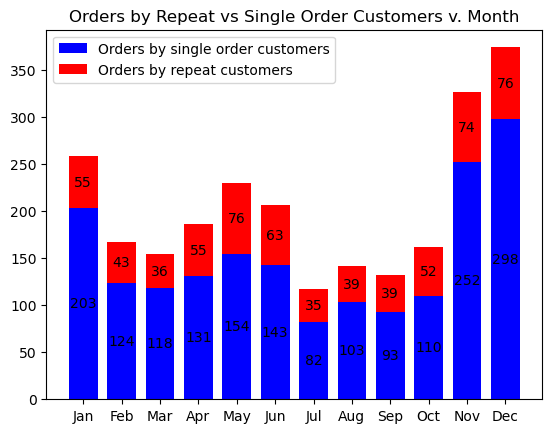

In [6]:
mult_cust_times = {}
single_cust_times = {}

for id, dates in orders_by_customer.items():
    if len(dates) > 1:
        mult_cust_times[id] = dates
    else:
        single_cust_times[id] = dates

single_by_month = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
multiple_by_month = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

months_abbreviations = [
    "Jan", "Feb", "Mar", 
    "Apr", "May", "Jun", 
    "Jul", "Aug", "Sep", 
    "Oct", "Nov", "Dec"
]

for id, dates in mult_cust_times.items():
    for datetime in dates:
        month = datetime.month
        multiple_by_month[month - 1] += 1

for id, dates in single_cust_times.items():
    single_by_month[dates[0].month - 1] += 1

fig, ax = plt.subplots()
bottom = 12

width = .75

for index in range(12):
    p = ax.bar(months_abbreviations[index], single_by_month[index], width, bottom=0, color='blue')
    q = ax.bar(months_abbreviations[index], multiple_by_month[index], width, bottom=single_by_month[index], color='red')

    ax.bar_label(p, label_type='center')
    ax.bar_label(q, label_type='center')

ax.set_title('Orders by Repeat vs Single Order Customers v. Month')
ax.legend(['Orders by single order customers', 'Orders by repeat customers'])

plt.show()

### Geolocation

Analyzing the time orders occurred at made us curious about exploring where these orders were occurring and if certain parts of the country had a higher repeat order rate. Using the data pulled using the Etsy API, we plotted the shipping addresses to see what countries were most common. However, we quickly realised all but 3 orders occurred within the USA. Thus, we decided to narrow down our search, to plot what states orders came from. 

We first started by plotting the number of orders shipped to each state to get a broad geographic understanding before focusing on repeat customers.

In [9]:
df = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/fips-unemp-16.csv",
                   dtype={"fips": str})
state = extract_data(orders, 'state')

state_list = Counter(state)
state_list = pd.DataFrame.from_dict(state_list, orient='index').reset_index()
state_list = state_list.rename(columns={"index":"state", 0:"number_of_orders"})
# state_list['country'] = state_list.country.apply(lambda x: pycountry_convert.country_name_to_country_alpha3(pycountry_convert.country_alpha2_to_country_name(x)))
fig = px.choropleth(state_list, locationmode = 'USA-states', locations='state', color='number_of_orders',
                        color_continuous_scale="Greens",
                        range_color=(0, 150),
                        scope="usa",
                        labels={'number_of_orders':'Number of Orders'},
                        )
fig.update_layout(title_text = 'Etsy Orders by State', geo_scope='usa', margin={"r":20,"t":80,"l":0,"b":30})
fig.show()

With the geographic distribution of the orders in mind, we created a map of the percent repeat customers in each state. To ensure the data shown was statistically significant, we filtered out the states with fewer than 20 customers. This prevents cases where a state may only have a few customers, so if one of them reorders the reorder rate is articially high. 

In [8]:
id_state = extract_data(orders, 'buyer_user_id', 'state')
state = extract_data(orders, 'state')

all_states_list = list(Counter(state).keys())
states_dict = {key: [] for key in all_states_list}

for customer in id_state:
    states_dict[customer[1]].append(customer[0])

percent_reorder_by_state = {}
for state, ids in states_dict.items():
    num_orders = Counter(Counter(states_dict[state]).values())
    one_order = 0
    multiple_orders = 0
    for number_of_orders, number_of_customers in num_orders.items():
        if number_of_orders == 1:
            one_order += number_of_customers
        if number_of_orders > 1:
            multiple_orders += number_of_customers
    if one_order + multiple_orders > 20:
        percent_reorder_by_state[state] = multiple_orders / (one_order + multiple_orders)

state_reorder_df = pd.DataFrame.from_dict(percent_reorder_by_state, orient='index').reset_index()
state_reorder_df = state_reorder_df.rename(columns={"index":"state", 0:"reorder_rate"})
fig = px.choropleth(state_reorder_df, locationmode = 'USA-states', locations='state', color='reorder_rate',
                        color_continuous_scale="Greens",
                        range_color=(0, .2),
                        scope="usa",
                        labels={'reorder_rate':'Percent Repeat Customers by State'},
                        )
fig.update_layout(title_text = 'Percent Repeat Customers by State', geo_scope='usa', margin={"r":20,"t":80,"l":0,"b":30})
fig.show()

### Reviews

We were also curious if people who leave a review are more likely to reorder than people who don't. To find ths out we:

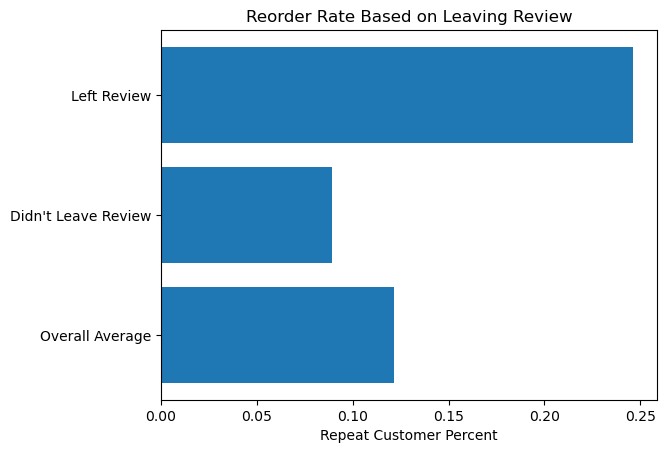

In [31]:
review_ids = extract_data(reviews, 'buyer_user_id')
num_orders_by_id = Counter(buyer_user_id)
num_reviews_by_id = Counter(review_ids)
left_review = list(num_reviews_by_id.keys())

count_reorders = 0
for id in left_review:
    if num_orders_by_id[id] > 1:
        count_reorders+=1

repeat_percent_yes_review = count_reorders/len(left_review)

count_reorders = 0
for id in list(num_orders_by_id.keys()):
    if num_orders_by_id[id] > 1:
        count_reorders+=1

repeat_percent_overall = count_reorders/len(list(num_orders_by_id.keys()))

count_reorders = 0
count_not_review = 0

for id in list(num_orders_by_id.keys()):
    if id not in left_review:
        count_not_review += 1
        if num_orders_by_id[id] > 1:
            count_reorders+=1

repeat_percent_no_review = count_reorders/count_not_review

fig, ax = plt.subplots()

# Example data
labels = ["Left Review", "Didn't Leave Review", "Overall Average"]
percents = [repeat_percent_yes_review, repeat_percent_no_review, repeat_percent_overall]

ax.barh(range(len(labels)), percents, align='center')
ax.set_yticks(range(len(labels)), labels=labels)
ax.invert_yaxis()
ax.set_xlabel('Repeat Customer Percent')
ax.set_title('Reorder Rate Based on Leaving Review')

plt.show()

### Order Size

We were also interested in whether customers who repeat order more or less on average than single time customers. This could influence the value of trying to attract more repeat customers because if they place small orders on average it may not be worth it.

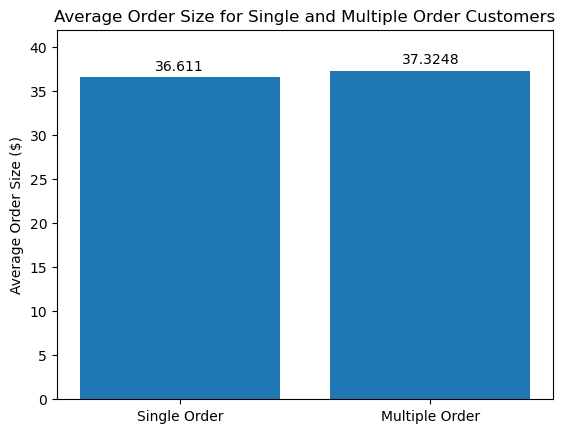

In [29]:
id_subtotal_dict = extract_data(orders, 'buyer_user_id', 'subtotal')
num_orders_by_id = Counter(buyer_user_id)

id_subtotal = []
for customer in id_subtotal_dict:
    id_subtotal.append([customer[0], customer[1]['amount']/customer[1]['divisor']])

single_order_customers = []
multiple_order_customers = []

for customer in id_subtotal:
    if num_orders_by_id[customer[0]] > 1:
        multiple_order_customers.append(customer[1])
    else:
        single_order_customers.append(customer[1])

single_order_value = statistics.mean(single_order_customers)
multiple_order_value = statistics.mean(multiple_order_customers)


fig, ax = plt.subplots()

labels = ["Single Order", "Multiple Order"]
amounts = [single_order_value, multiple_order_value]

bars = ax.bar(range(len(labels)), amounts, align='center')
ax.set_xticks(range(len(labels)), labels=labels)
ax.bar_label(bars, padding=3, label_type='edge')
ax.set_ylabel('Average Order Size ($)')
ax.set_title('Average Order Size for Single and Multiple Order Customers')
ax.set_ylim(0, 42)

plt.show()

## Interpreting the Data

What summaries or visualizations did you create?

What are the interesting and/or important parts of these summaries or visualizations?

How do these results answer your questions or tell your story?

### What we found

### What this means

### How we're going to act on this

## Concluding remarks

What are the important insights that the reader should get from this project?

What are the ethical considerations surrounding the data sourcing?
What are the contextual or ethical implications of your topic or work?

For the most part, this project creates no ethical concerns. However, it is important to notice that some sensitive data is used for the geographical analysis, such as zipcodes. While zipcodes per se are not someting that can identify a specific person, they can be used along with other data to do so. Furthermore, while we chose not to use the full address of people, it is also important to notice that the API does provide this data if requested. Therefore, there is a potential for misuse of this sensitive data.

What lessons did you learn as you did the project?

What were the most difficult, challenging, or frustrating parts of the project?

One of the most frustrating parts of the project was creating the interactive map graphs. This is because they were created using a library that neither of us have used before, and therefore knew nothing about. Furthermore, another challenging part of this project was obtaining the API data. API calls were new for both of us, and the specific syntax and error codes were difficult to understand at first. This is why we initially thought of using a separate library to write the API calls, but abandoned this idea to maintain the overall structure of the project simpler. 

### Assumptions and Future Improvements
In what ways would you extend or change your project if you had more time?

If we had more time, we believe it would be useful to dive deeper into the psychology of the customer, understanding exactly what elements drive a customer to reorder. It could also be very interesting to assess the success of different customer retention techniques, such as newsletters, promo codes, sales, bundles, or else. 